# 1. Import thư viện và các tài nguyên

## 1.1. Thư viện và gg drive

In [ ]:
!pip install seaborn -q
!pip install scikit-learn -q
!pip install tensorflow -q
!pip install keras -q
!pip install -U gdown

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.2. Tải và giải nén các bộ pre-trained word embeddings cho tiếng Việt

Để mô hình có thể học tốt hơn ý nghĩa và ngữ nghĩa của từ, chúng ta thường sử dụng các **word embeddings** đã được huấn luyện trước (pre-trained) trên tập dữ liệu lớn. Việc này giúp mô hình tận dụng được tri thức ngôn ngữ chung, tăng hiệu quả ngay cả với lượng dữ liệu huấn luyện nhỏ.

#### **A. fastText embedding**

Tải bộ vector fastText cho tiếng Việt:**


In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.vi.300.vec.gz

--2025-07-26 06:49:54--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.vi.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.111, 13.35.37.84, 13.35.37.90, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1235219084 (1.1G) [binary/octet-stream]
Saving to: ‘cc.vi.300.vec.gz’

cc.vi.300.vec.gz    100%[===================>]   1.15G  80.6MB/s    in 6.9s    

2025-07-26 06:50:01 (172 MB/s) - ‘cc.vi.300.vec.gz’ saved [1235219084/1235219084]



Giải nén file vector:

In [ ]:
import gzip
import shutil
with gzip.open('cc.vi.300.vec.gz', 'rb') as f_in:
    with open('cc.vi.300.vec', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

#### **B. PhoW2V embedding (Word2Vec của VinAI)**
Tải word2vec embedding theo word và theo syllable  (tải từ trên máy local lên):

Link git repo https://github.com/datquocnguyen/PhoW2V?tab=readme-ov-file

In [ ]:
!gdown --id 1EEF2xFmL9FZKY9dIwW3fAaHUwBXSRCdi -O /content/word2vec_vi_syllables_300dims.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1EEF2xFmL9FZKY9dIwW3fAaHUwBXSRCdi
From (redirected): https://drive.google.com/uc?id=1EEF2xFmL9FZKY9dIwW3fAaHUwBXSRCdi&confirm=t&uuid=94827ff5-7236-4523-a362-35a931b19db6
To: /content/word2vec_vi_syllables_300dims.zip
100% 1.42G/1.42G [00:13<00:00, 102MB/s]


In [ ]:
from zipfile import ZipFile

zipf = ZipFile('word2vec_vi_syllables_300dims.zip')
zipf.extractall()

In [ ]:
!gdown --id 1e_zLgwkt1LmmC2rY7DOaPgjwwC-p3h0F -O /content/word2vec_vi_words_300dims.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1e_zLgwkt1LmmC2rY7DOaPgjwwC-p3h0F
From (redirected): https://drive.google.com/uc?id=1e_zLgwkt1LmmC2rY7DOaPgjwwC-p3h0F&confirm=t&uuid=10ffaa15-a4f3-454a-98a8-9477f2a59d2a
To: /content/word2vec_vi_words_300dims.zip
100% 2.32G/2.32G [00:53<00:00, 43.6MB/s]


In [ ]:
zipf = ZipFile('word2vec_vi_words_300dims.zip')
zipf.extractall()

## 1.3. Config.yml


In [ ]:
import yaml

path = "/content/drive/MyDrive/1.PROJECTS/[TeamPe][BIT][BGRA2025]/NLP/Code/config.yaml"

with open(path, 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)



In [ ]:
import os
import random
import numpy as np
import tensorflow as tf

def set_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


# 2. Dataset


In [ ]:
import yaml
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def vi_preprocess(text):
    # Lowercase
    text = text.lower()
    # Loại bỏ ký tự không phải chữ/số
    text = re.sub(r"[^\w\s]", " ", text)
    # Loại bỏ số
    # text = re.sub(r"\d+", " ", text)
    # Chuẩn hóa khoảng trắng
    text = re.sub(r"\s+", " ", text).strip()
    return text

class DataLoader:
    def __init__(self, config_path, mode='train', embedding_type=None):

        # Load config từ file
        with open(config_path, 'r', encoding='utf-8') as f:
            self.config = yaml.safe_load(f)

        self.mode = mode

        # Lấy đường dẫn file theo mode (train/test/val/warmup)
        paths = self.config['paths']
        if mode not in paths:
            raise ValueError(f"Mode '{mode}' không có trong config.")
        self.data_path = paths[mode]
        # Thay thế {paths.base} nếu cần
        base = paths.get("base", "")
        if "{paths.base}" in self.data_path:
            self.data_path = self.data_path.replace("{paths.base}", base)

        # Các tham số tiền xử lý
        bilstm_conf = self.config['preprocessing']['bilstm']
        self.max_num_words = bilstm_conf.get('max_features', 2500)
        self.max_seq_length = bilstm_conf.get('maxlen', 500)
        self.clean_text = bilstm_conf.get('clean_text', True)

        self.tokenizer = Tokenizer(num_words=self.max_num_words, oov_token="<OOV>")
        self.texts, self.labels = self.load_data()
        self.prepare_data()

        # Xử lý embedding ngoài nếu được yêu cầu
        self.embedding_matrix = None
        if embedding_type is not None:
            self.embedding_matrix = self.get_embedding_matrix(embedding_type)

    def load_data(self):
        df = pd.read_csv(self.data_path)
        texts = df['post_message'].astype(str).tolist()
        if self.clean_text:
            texts = [vi_preprocess(t) for t in texts]
        if 'label' in df.columns:
            labels = df['label'].astype(int).values
        else:
            labels = None
        return texts, labels

    def prepare_data(self):
        # Fit tokenizer trên toàn bộ texts (thường chỉ fit trên train)
        self.tokenizer.fit_on_texts(self.texts)
        sequences = self.tokenizer.texts_to_sequences(self.texts)
        self.padded_sequences = pad_sequences(
            sequences, maxlen=self.max_seq_length, padding='post', truncating='post'
        )

    def get_data(self):
        print(f"Load dataset: {self.mode}")
        return self.padded_sequences, self.labels

    def get_tokenizer(self):
        return self.tokenizer

    def get_config(self):
        return self.config

    def get_embedding_matrix(self, embedding_type=None, cache_dir='.', force_rebuild=False):
        """
        Trả về embedding matrix: ưu tiên load từ cache .npy (nếu có),
        nếu chưa có sẽ tự động build từ file text embedding, lưu vào cache .npy.
        Nếu embedding_type=None sẽ trả về random matrix.
        """
        embed_dim = getattr(self, 'embed_dim', 300)
        num_words = min(getattr(self, 'max_num_words', 2500), len(self.tokenizer.word_index) + 1)

        if embedding_type is None:
            print("[DataLoader] Không dùng embedding ngoài, tạo random embedding_matrix.")
            return np.random.uniform(-0.05, 0.05, (self.max_num_words, embed_dim))

        # Đặt tên cache theo tokenizer + embedding_type để tránh nhầm lẫn
        cache_file = os.path.join(
            cache_dir,
            f"embedding_matrix_{embedding_type}_{num_words}_{embed_dim}.npy"
        )
        if os.path.exists(cache_file) and not force_rebuild:
            print(f"[DataLoader] Loading cached embedding matrix: {cache_file}")
            return np.load(cache_file)

        # Lấy embedding_path từ config hoặc truyền vào class khi init
        try:
            embedding_path = self.embedding_path if hasattr(self, 'embedding_path') else \
                self.config['paths']['embeddings'][embedding_type]
        except Exception as e:
            raise ValueError(f"Không tìm thấy đường dẫn embedding {embedding_type}: {e}")

        print(f"[DataLoader] Building embedding matrix từ {embedding_path}")
        vocab = set(self.tokenizer.word_index.keys())
        embedding_matrix = np.random.uniform(-0.05, 0.05, (self.max_num_words, embed_dim))
        with open(embedding_path, "r", encoding="utf-8", errors="ignore") as f:
            first_line = f.readline()
            try:
                int(first_line.split()[1])
            except:
                f.seek(0)
            for line in f:
                values = line.rstrip().split()
                word = values[0]
                if word in vocab:
                    i = self.tokenizer.word_index[word]
                    if i >= num_words:
                        continue
                    try:
                        vec = np.asarray(values[1:], dtype='float32')
                    except Exception as e:
                        print(f"Bỏ qua từ {word} do lỗi: {e}")
                        continue
                    if vec.shape[0] == embed_dim:
                        embedding_matrix[i] = vec

        os.makedirs(os.path.dirname(cache_file), exist_ok=True)
        np.save(cache_file, embedding_matrix)

        print(f"[DataLoader] Đã lưu embedding matrix cache tại {cache_file}")
        return embedding_matrix





# 3. BiLSTM Model

In [ ]:
from keras.models import Sequential, load_model
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

class BiLSTMModel:
    def __init__(
        self,
        vocab_size,
        embedding_dim=128,
        max_seq_length=100,
        lstm_units=64,
        dropout_rate=0.2,
        output_dim=1,
        output_activation="sigmoid",
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    ):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_seq_length = max_seq_length
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.output_dim = output_dim
        self.output_activation = output_activation

                # --- CHỌN LOSS THEO THAM SỐ ---
        if str(loss).lower() == "focal":
            self.loss = focal_loss_fixed
            print("=> Sử dụng Focal Loss")
        else:
            self.loss = loss  # "binary_crossentropy" hoặc tên loss khác
            print("=> Sử dụng loss:", loss)

        self.optimizer = optimizer
        self.metrics = [
            "accuracy",
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
        self.model = self.build_model()
        self.model.compile(
            loss=self.loss,
            optimizer=self.optimizer,
            metrics=self.metrics
        )

    def build_model(self):
        model = Sequential()
        model.add(Embedding(self.vocab_size, self.embedding_dim, input_length=self.max_seq_length))
        model.add(Bidirectional(LSTM(self.lstm_units, return_sequences=False)))
        model.add(Dropout(self.dropout_rate))
        model.add(Dense(self.output_dim, activation=self.output_activation))
        return model

    def summary(self):
        return self.model.summary()

    def save(self, filepath):
        self.model.save(filepath)

    def load(self, filepath):
        self.model = load_model(filepath)

In [ ]:
from keras.saving import register_keras_serializable
import tensorflow as tf
from keras import backend as K

@register_keras_serializable(package="custom", name="focal_loss_fixed")
def focal_loss_fixed(y_true, y_pred):
    gamma = 2.0
    alpha = 0.5
    y_true = tf.cast(y_true, tf.float32)
    epsilon = K.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    loss = -alpha * tf.pow(1. - pt, gamma) * tf.math.log(pt)
    return tf.reduce_mean(loss)


# 4. Class Trainer

In [ ]:
import csv
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, CSVLogger
import os

class Trainer:
    def __init__(
        self,
        model,
        X_train,
        y_train,
        X_val=None,
        y_val=None,
        batch_size=32,
        epochs=10,
        callbacks=None,
        validation_split=0.2,
        use_validation_data=True,
        verbose=1,
        checkpoint_path=None,
        log_path=None,
        class_weights=None,
    ):
        self.model = model  # Là model Keras (ví dụ model_obj.model)
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.batch_size = batch_size
        self.epochs = epochs
        self.validation_split = validation_split
        self.use_validation_data = use_validation_data
        self.verbose = verbose
        self.checkpoint_path = checkpoint_path
        self.log_path = log_path
        self.callbacks = callbacks if callbacks is not None else self.default_callbacks()
        self.class_weights = class_weights

        # Khởi tạo callbacks
        if self.checkpoint_path is not None:
            # Lưu model theo chuẩn .keras, monitor val_loss
            self.callbacks.append(
                ModelCheckpoint(
                    filepath=self.checkpoint_path,
                    monitor='val_loss',
                    save_best_only=True,
                    verbose=1,
                )
            )
        # Tự build model nếu chưa build để tránh param=0 khi summary
        self._auto_build()

    def _auto_build(self):
        # Nếu model chưa được build (layers param=0), hãy build trước với shape phù hợp
        # Cách này hoạt động nếu bạn biết shape input (vd: max_seq_length)
        if hasattr(self.model, 'built') and not self.model.built:
            # Lấy shape từ layer đầu tiên nếu có, hoặc đoán theo chuẩn NLP
            for layer in self.model.layers:
                if hasattr(layer, 'input_length'):
                    seq_len = getattr(layer, 'input_length', 100)
                    self.model.build(input_shape=(None, seq_len))
                    break
            # Hoặc dùng cứng nếu bạn biết chắc chiều dài:
            # self.model.build(input_shape=(None, 500))
        # In summary để kiểm tra, có thể comment nếu không cần
        self.model.summary()

    def default_callbacks(self):
        callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]

        if self.log_path:
            log_dir = os.path.dirname(self.log_path)
            if log_dir and not os.path.exists(log_dir):
                os.makedirs(log_dir)

            # CSVLogger: ghi log training vào file CSV
            callbacks.append(CSVLogger(self.log_path, append=False))

            # TensorBoard: log cho TensorBoard
            tensorboard_dir = os.path.join(log_dir, "tensorboard")
            callbacks.append(TensorBoard(log_dir=tensorboard_dir, histogram_freq=1))

        return callbacks

    def train(self):
        if self.use_validation_data and self.X_val is not None and self.y_val is not None:
            history = self.model.fit(
                self.X_train, self.y_train,
                validation_data=(self.X_val, self.y_val),
                batch_size=self.batch_size,
                epochs=self.epochs,
                callbacks=self.callbacks,
                verbose=self.verbose,
                class_weight=self.class_weights
            )
        else:
            history = self.model.fit(
                self.X_train, self.y_train,
                validation_split=self.validation_split,
                batch_size=self.batch_size,
                epochs=self.epochs,
                callbacks=self.callbacks,
                verbose=self.verbose,
                class_weight=self.class_weights
            )
        return history


In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
from tensorflow.keras.callbacks import Callback
import numpy as np

class BinaryMetricsCallback(Callback):
    def __init__(self, X_val, y_val, threshold=0.5):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        # Dự đoán xác suất
        y_pred_prob = self.model.predict(self.X_val)

        # Nhãn dự đoán 0/1 dựa theo ngưỡng threshold
        y_pred = (y_pred_prob > self.threshold).astype(int).reshape(-1)

        # Nếu y_val là one-hot vector thì chuyển thành nhãn
        y_true = self.y_val if len(self.y_val.shape) == 1 else np.argmax(self.y_val, axis=1)

        # Tính các chỉ số
        f1 = f1_score(y_true, y_pred, average='binary')
        recall = recall_score(y_true, y_pred, average='binary')
        precision = precision_score(y_true, y_pred, average='binary')
        try:
            auc = roc_auc_score(y_true, y_pred_prob)
        except ValueError:
            auc = float('nan')  # xảy ra khi chỉ có 1 lớp trong batch val

        # In kết quả
        print(f" — val_precision: {precision:.4f} — val_recall: {recall:.4f} — val_f1: {f1:.4f} — val_auc: {auc:.4f}")

        # Ghi vào logs để có thể lưu hoặc dùng với TensorBoard/CSVLogger
        if logs is not None:
            logs['val_precision'] = precision
            logs['val_recall'] = recall
            logs['val_f1'] = f1
            logs['val_auc'] = auc

# 5. Class Evaluator

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
import seaborn as sns

class Evaluator:
    def __init__(self, model):
        self.model = model  # Là model Keras (.model của BiLSTMModel)

    def evaluate(self, X_test, y_test, batch_size=32):
        results = self.model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
        metric_names = self.model.metrics_names

        for name, value in zip(metric_names, results):
            print(f"{name}: {value:.4f}")

        return dict(zip(metric_names, results))


    def classification_report(self, X_test, y_test, threshold=0.5):
        y_pred_prob = self.model.predict(X_test)
        y_pred = (y_pred_prob > threshold).astype(int)

        print(f"\n📋 Classification Report (threshold = {threshold}):")
        print(classification_report(y_test, y_pred, digits=4))

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        print(f"\n🔍 Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}")


    def plot_history(self, history):
        # Plot loss
        plt.figure()
        plt.plot(history.history['loss'], label='Train Loss')
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Plot accuracy
        if 'accuracy' in history.history:
            plt.figure()
            plt.plot(history.history['accuracy'], label='Train Acc')
            if 'val_accuracy' in history.history:
                plt.plot(history.history['val_accuracy'], label='Val Acc')
            plt.title('Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.show()

    def confusion_matrix(self, X_test, y_test, threshold=0.5):
        y_pred_prob = self.model.predict(X_test)

        y_pred = (y_pred_prob > threshold).astype(int)

        cm = confusion_matrix(y_test, y_pred)

        print("\n📊 Confusion Matrix:")
        print(cm)

        # Trực quan hóa
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix (threshold={threshold})')
        plt.show()


    def predict_single(self, input_sequence):
        # input_sequence đã pad sẵn
        y_prob = self.model.predict(input_sequence)
        return int(y_prob[0][0] > 0.5)

    def plot_roc_auc(self, X_test, y_test):
        y_score = self.model.predict(X_test)

        # Binary classification
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()



# 6. Run pipeline

In [ ]:
%%writefile "/content/drive/MyDrive/1.PROJECTS/[TeamPe][BIT][BGRA2025]/NLP/Code/config.yaml"

mode: train
seed: 123

paths:
  train: "/content/drive/MyDrive/1.PROJECTS/[TeamPe][BIT][BGRA2025]/NLP/Code/reintel_dataset/train.csv"
  test: "/content/drive/MyDrive/1.PROJECTS/[TeamPe][BIT][BGRA2025]/NLP/Code/reintel_dataset/test.csv"
  val: "/content/drive/MyDrive/1.PROJECTS/[TeamPe][BIT][BGRA2025]/NLP/Code/reintel_dataset/val.csv"
  warmup: "/content/drive/MyDrive/1.PROJECTS/[TeamPe][BIT][BGRA2025]/NLP/Code/reintel_dataset/warmup.csv"
  embeddings:
    fasttext: "cc.vi.300.vec" #fasttext
    word2vec: "word2vec_vi_syllables_300dims.txt"

preprocessing:
  bilstm:
    max_features: 2500
    maxlen: 500
    embed_size: 300
    clean_text: true
  phobert:
    max_sequence_length: 256
    clean_text: true

split:
  valid_size: 0.33
  random_state: 42  # dùng chung cho cả seed và train_test_split

models:
  bilstm:
    embedding_dim: 300
    max_seq_length: 500
    lstm_units: 128
    dropout_rate: 0.3
    output_dim: 1
    output_activation: "sigmoid"
    loss: "focal"  # hoặc "binary_crossentropy"
    optimizer: "adam"
    embedding_type: #"fasttext" #
    metrics: ["accuracy", "precision", "recall", "auc"]
    use_f1_callback: true  # để dùng BinaryMetricsCallback()

training:
  batch_size: 32
  epochs: 10
  checkpoint_path: "/content/drive/MyDrive/1.PROJECTS/[TeamPe][BIT][BGRA2025]/NLP/Code/checkpoints/best_model.keras"
  log_path: "/content/drive/MyDrive/1.PROJECTS/[TeamPe][BIT][BGRA2025]/NLP/Code/logs/training_log.csv"
  early_stopping:
    patience: 3
  device: auto


Overwriting /content/drive/MyDrive/1.PROJECTS/[TeamPe][BIT][BGRA2025]/NLP/Code/config.yaml


[DataLoader] Loading cached embedding matrix: ./embedding_matrix_fasttext_2500_300.npy
Load dataset: train
[DataLoader] Loading cached embedding matrix: ./embedding_matrix_fasttext_2500_300.npy
Load dataset: val
Load dataset: test
=> Sử dụng Focal Loss


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

{0: np.float64(0.6012518915944421), 1: np.float64(2.9690896739130435)}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
 — val_precision: 0.3750 — val_recall: 0.0366 — val_f1: 0.0667 — val_auc: 0.5879

Epoch 1: val_loss improved from inf to 0.10241, saving model to /content/drive/MyDrive/1.PROJECTS/[TeamPe][BIT][BGRA2025]/NLP/Code/checkpoints/best_model.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 32s 78ms/step - accuracy: 0.8446 - auc: 0.7331 - loss: 0.0512 - precision: 0.4999 - recall: 0.1995 - val_accuracy: 0.8272 - val_auc: 0.5879 - val_loss: 0.1024 - val_precision: 0.3750 - val_recall: 0.0366 - val_f1: 0.0667
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
 — val_precision: 0.3000 — val_recall: 0.0366 — val_f1: 0.0652 — val_auc: 0.5251

Epoch 2: val_loss did not improve from 0.10241
274/274 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.9397 - auc: 0.9638 - loss: 0.0225 - precision: 0.8327 - recall: 0.7859 - val_accuracy: 0.8230 - val_auc: 0.5251 - val_loss: 0.1545 - val_precision: 0.3000 - val_recall: 0.0366 - val_f1: 0.0652
Epoch 3/10
16/16 ━━━━━━━━━━

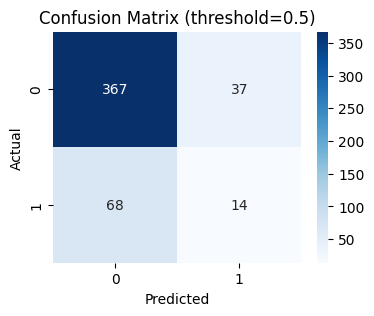

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


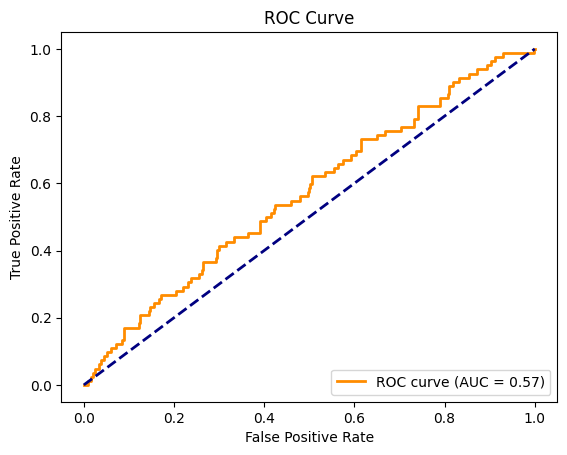

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import builtins


zip = builtins.zip

# Đường dẫn config.yaml
config_path = "/content/drive/MyDrive/1.PROJECTS/[TeamPe][BIT][BGRA2025]/NLP/Code/config.yaml"
with open(config_path, 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)
set_seed(config["seed"])


# 1. Load data train và validation
# Load tập train (áp dụng preprocessing nếu bật clean_text trong config)
train_loader = DataLoader(config_path, mode="train", embedding_type=config['models']['bilstm']['embedding_type'])  # "fasttext" hoặc "word2vec", hoặc None
X_train, y_train = train_loader.get_data()
tokenizer = train_loader.get_tokenizer()

embedding_matrix = train_loader.get_embedding_matrix(
    embedding_type= config['models']['bilstm']['embedding_type'],  # hoặc 'word2vec', hoặc None
)

# Load tập validation (phải dùng lại tokenizer đã fit trên train!)
val_loader = DataLoader(config_path, mode="val")
val_loader.tokenizer = tokenizer
val_loader.prepare_data()  # Re-tokenize + pad với tokenizer đã fit từ train
X_val, y_val = val_loader.get_data()

#Load test set
test_loader = DataLoader(config_path, mode="test")
test_loader.tokenizer = tokenizer
test_loader.prepare_data()
X_test, y_test = test_loader.get_data()


# 2. Khởi tạo model với tham số từ config
bilstm_conf = config['models']['bilstm']
pre_conf = config['preprocessing']['bilstm']

model_obj = BiLSTMModel(
    vocab_size=len(tokenizer.word_index) + 1,
    embedding_dim=pre_conf.get("embed_size", 300),
    max_seq_length=pre_conf.get("maxlen", 500),
    lstm_units=bilstm_conf.get("lstm_units", 128),
    dropout_rate=bilstm_conf.get("dropout_rate", 0.3),
    output_dim=bilstm_conf.get("output_dim", 1),
    output_activation=bilstm_conf.get("output_activation", "sigmoid"),
    loss=bilstm_conf.get("loss", "binary_crossentropy"),
    optimizer=bilstm_conf.get("optimizer", "adam")
)

model_obj.summary()

# 3. Khởi tạo Trainer và train
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print(class_weights)

binary_metrics_cb = BinaryMetricsCallback(X_val, y_val)
trainer = Trainer(
    model=model_obj.model,
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    batch_size=32,
    epochs=10,
    checkpoint_path=config['training']['checkpoint_path'],
    log_path=config['training']['log_path'],
    callbacks=[binary_metrics_cb],
    class_weights = class_weights
)
history = trainer.train()
model_obj.save("best_model.keras")

# 4. Đánh giá & trực quan hóa

evaluator = Evaluator(model_obj.model)

evaluator.evaluate(X_test, y_test)
evaluator.classification_report(X_test, y_test)
evaluator.confusion_matrix(X_test, y_test)
evaluator.plot_roc_auc(X_test, y_test)


In [ ]:
from keras.models import load_model

# Load lại mô hình
loaded_model = load_model(
    "/content/drive/MyDrive/1.PROJECTS/[TeamPe][BIT][BGRA2025]/NLP/Code/checkpoints/best_model.keras",
    custom_objects={"focal_loss_fixed": focal_loss_fixed},
    compile=True)

# Tạo evaluator mới
evaluator = Evaluator(loaded_model)

evaluator.evaluate(X_test, y_test)
evaluator.classification_report(X_test, y_test)
evaluator.confusion_matrix(X_test, y_test)
evaluator.plot_roc_auc(X_test, y_test)

